In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import statsmodels.api as sm
from math import log,sqrt,exp
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Problem1

In [48]:
def option_price(S, X, T, r, q, sigma, option='Call'):
    d1 = (np.log(S / X) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'Call':
        value = S * np.exp(-q * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'Put':
        value = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        print("The input option is not valid")

    return value

In [49]:
time_to_maturity = (dt.datetime(2023, 3, 17) - dt.datetime(2023, 3, 3)).days
time_to_maturity

14

In [50]:
# Input section
T = time_to_maturity / 365
r = 0.0525
q = 0.0053
sigmas = np.linspace(0.1, 0.8, 100) # implied volatilities

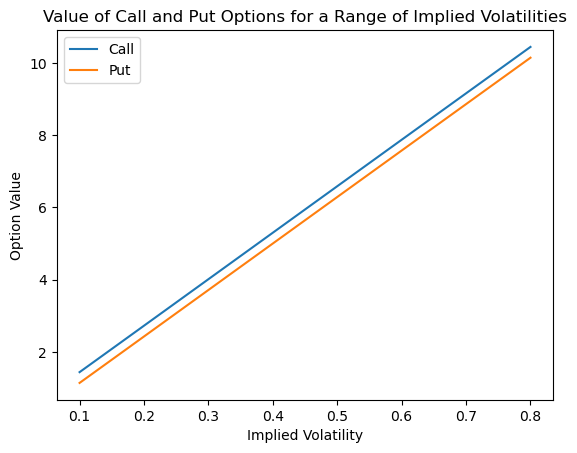

In [51]:
# Calculate values for call and put options
S = 165
X0 = 165
call_values = [option_price(S, X0, T, r, q, sigma, 'Call') for sigma in sigmas]
put_values = [option_price(S, X0, T, r, q, sigma, 'Put') for sigma in sigmas]

# Plot the results
plt.plot(sigmas, call_values, label='Call')
plt.plot(sigmas, put_values, label='Put')
plt.legend()
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Value of Call and Put Options for a Range of Implied Volatilities')
plt.show()

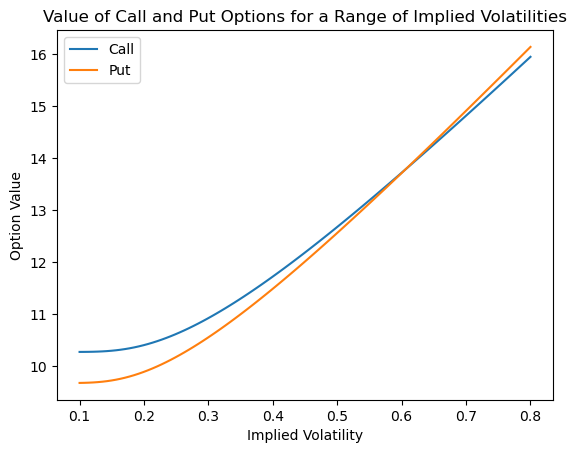

In [52]:
X_Call = 155
X_Put = 175
# Calculate values for call and put options
call_values = [option_price(S, X_Call, T, r, q, sigma, 'Call') for sigma in sigmas]
put_values = [option_price(S, X_Put, T, r, q, sigma, 'Put') for sigma in sigmas]

# Plot the results
plt.plot(sigmas, call_values, label='Call')
plt.plot(sigmas, put_values, label='Put')
plt.legend()
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Value of Call and Put Options for a Range of Implied Volatilities')
plt.show()

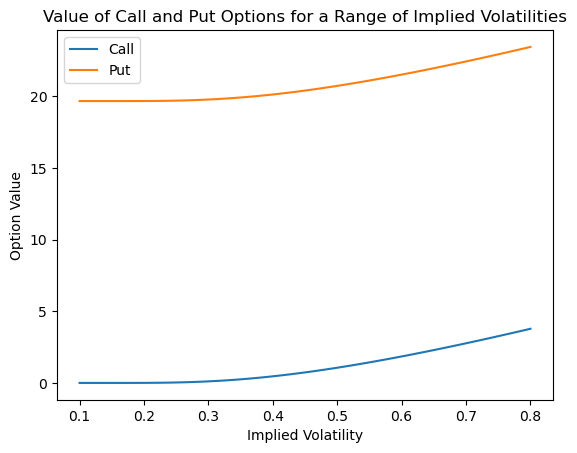

In [53]:
X_Call = 185
X_Put = 185
# Calculate values for call and put options
call_values = [option_price(S, X_Call, T, r, q, sigma, 'Call') for sigma in sigmas]
put_values = [option_price(S, X_Put, T, r, q, sigma, 'Put') for sigma in sigmas]

# Plot the results
plt.plot(sigmas, call_values, label='Call')
plt.plot(sigmas, put_values, label='Put')
plt.legend()
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Value of Call and Put Options for a Range of Implied Volatilities')
plt.show()

# Problem2

In [54]:
def find_implied_volatility(S,X,T,r,q, value, initvol, option = 'Call'):
    option = str(option)
    def sol_vol(sigma, S, X, T, r, q, option, value):
        return option_price(S, X, T, r, q, sigma, option = option) - value
    vol = fsolve(sol_vol, initvol, args=(S, X, T, r, q, option, value))
    return vol[0]

In [55]:
S =170.15
r = 0.0525
q = 0.0057
aapl_options = pd.read_csv("AAPL_Options.csv")
curdate= dt.datetime(2023,10,30)
aapl_options['Expiration']=aapl_options['Expiration'].astype("datetime64[ns]")
aapl_options['T'] = aapl_options['Expiration'].apply(lambda x: round((x-curdate).days/365,6))

In [56]:
def row_fun(row, S, r, q):
    vol = find_implied_volatility(S, row['Strike'], row['T'], r, q, row['Last Price'], 0.2, row['Type'])
    return vol
aapl_options['Implied Vol'] = aapl_options.apply(row_fun, args = (S, r, round(r-q,4)), axis=1)

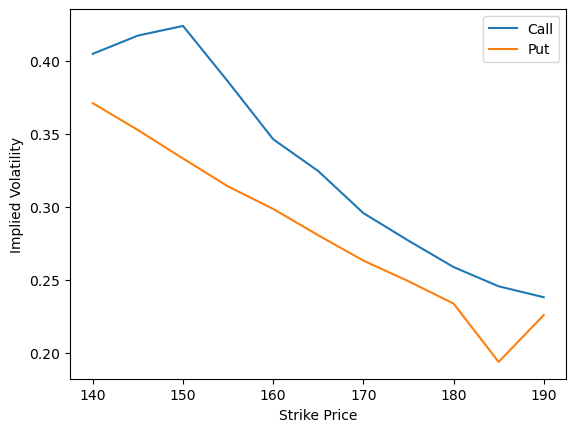

In [57]:
# Plot the results
aapl_call = aapl_options[aapl_options['Type']=="Call"]
aapl_put = aapl_options[aapl_options['Type']=="Put"]
plt.plot(aapl_call['Strike'],aapl_call['Implied Vol'],label="Call")
plt.plot(aapl_put['Strike'],aapl_put['Implied Vol'],label="Put")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")
plt.legend()

# Problem3

In [58]:
S = 170.15
r = 0.0525
q = 0.0057
portfolio = pd.read_csv("problem3.csv")
curdate = dt.datetime(2023,10,30)
portfolio['ExpirationDate']=portfolio['ExpirationDate'].astype("datetime64[ns]")
portfolio['T'] = portfolio['ExpirationDate'].apply(lambda x: round((x-curdate).days/365,6))

In [59]:
# Caculate implied volatility
def row_function_portfolio(row,S,r,q):
    vol = find_implied_volatility(S,row['Strike'],row['T'],r,q,row['CurrentPrice'],0.2, row['OptionType'])
    return vol
portfolio['Implied Vol'] = portfolio[portfolio['Type']=='Option'].apply(row_function_portfolio,args=(S,r,round(r-q,4)),axis=1)

# Calculate value for each option given the underlying
def value_calculation(row,S,r,q,daysahead):
    if row['Type'] == 'Stock':
        return S
    else:
        return option_price(S,row['Strike'],row['T']-daysahead/365,r,q,row['Implied Vol'],row['OptionType'])*row['Holding']

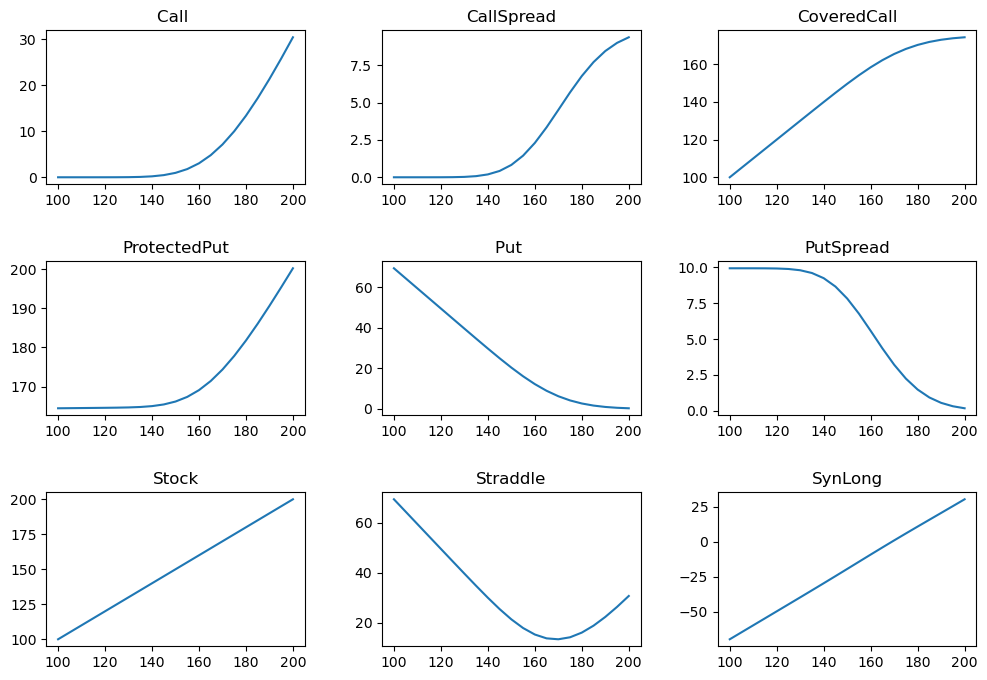

In [60]:
underlying_list = np.linspace(100,200,num=21).tolist()
portfolio_values = pd.DataFrame(portfolio['Portfolio'])
for S in underlying_list:
    portfolio_values[S]=portfolio.apply(value_calculation,args=(S,r,round(r-q,4),0),axis=1)
# Portfolio values under the range
portfolio_range = portfolio_values.groupby('Portfolio').sum().T
# Plot the shape for each portfolio
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(12,8))
for i in range(len(portfolio_range.columns)):
    x_ax = i // 3
    y_ax = i % 3
    portfolio_name = portfolio_range.columns[i]
    axs[x_ax,y_ax].plot(portfolio_range.index,portfolio_range[portfolio_name])
    axs[x_ax,y_ax].set_title(portfolio_name)
fig.subplots_adjust(wspace=0.3, hspace=0.5)

In [61]:
daily_prices = pd.read_csv("DailyPrices.csv")
# Calculate the log returns of AAPL
aapl_log = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1))
# Demean the series so there is 0 mean
aapl_log = aapl_log-aapl_log.mean()

In [62]:
# Simulate using AR1
def ar1_sim(r,ndays,p0,nsim=10000,seed=10):
    ar1_fit = sm.tsa.arima.ARIMA(r, order=(1, 0, 0))
    con,beta,s= ar1_fit.fit().params[0],ar1_fit.fit().params[1],np.sqrt(ar1_fit.fit().params[2])
    np.random.seed(seed)
    rsim = np.zeros((nsim,ndays))
    for i in range(nsim):
        rsim[i,0] = con+ beta*r.iloc[-1] + s*np.random.normal()
        for j in range(1,ndays):
            rsim[i,j]=con+ beta*rsim[i,j-1] + s*np.random.normal()
    rsim_cum = np.sum(rsim,axis=1)
    psim = np.zeros(nsim)
    for i in range(nsim):
        psim[i]=p0*exp(rsim_cum[i])
    return psim

underlying_sim = ar1_sim(aapl_log,10,S,seed=20)

In [63]:
portfolio_current = portfolio.apply(value_calculation,args=(S,r,round(r-q,4),0),axis=1)
pl_list = []
for i in range(len(underlying_sim)):
    pl = portfolio.apply(value_calculation,args=(underlying_sim[i],r,round(r-q,4),10),axis=1) - portfolio_current
    pl_list.append(pl)
pl_sim = pd.concat(pl_list,axis=1)
pl_sim.set_index(portfolio['Portfolio'],inplace=True)
port_sim = pl_sim.groupby(level=0).sum().T

In [64]:
def VaR(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    return -v

In [65]:
def ES(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    es = a[a<=v].mean()
    return -es

In [66]:
# Calculate Mean, VaR and ES
portfolio_mean = port_sim.mean(axis=0)
portfolio_stat = pd.DataFrame(portfolio_mean,columns=['Mean'])
var = []
es =[]
for col in port_sim.columns:
    var.append(VaR(port_sim[col].values))
    es.append(ES(port_sim[col].values))
portfolio_stat['VaR'] = var
portfolio_stat['ES'] = es

In [67]:
print(portfolio_stat)

                  Mean        VaR         ES
Portfolio                                   
Call          0.604972  15.797181  18.914327
CallSpread   -0.160003   1.986177   2.990954
CoveredCall  -0.130899   2.454929   4.122473
ProtectedPut  0.584594  16.685168  20.277700
Put           0.098163   0.273888   0.276006
PutSpread     0.077448   0.157878   0.159198
Stock         0.535874  17.441673  21.771266
Straddle      0.703135  14.538330  16.547867
SynLong       0.506809  17.056031  21.280787
